In [1]:
using GridPotentialFlow
using Plots

PhysicalGrid{2}((252, 104), (126, 52), 0.04, ((-5.0, 5.0), (-2.04, 2.04)))

#### Flat plate

We can apply this method also to our flat plate example and compare it to the Biot-Savart method from the `PotentialFlow.jl` package.

Because we create the `PotentialFlow.jl` model with a moving plate instead of a uniform flow, we specify a translational velocity. The `GridPotentialFlow.jl` model will still use a moving body coordinate system and thus a uniform flow that equals the negative translational velocity.

Time stepping

In [541]:
c = 1.0;   # chord length
Δx = 0.01
xlim = (-1,1)
ylim = (-0.5,0.5)
g = PhysicalGrid(xlim,ylim,Δx);

In [645]:
Γv = 1.0
Γb = -1.0
xv, yv = 0.5, 0.25;

In [646]:
Δt = 5e-3;
tf = Δt; #8.0;
T = 0.0:Δt:tf;

In [647]:
dsdx = 1.4
plate = RigidBodyTools.Plate(c,dsdx*Δx)
#pfb = PotentialFlowBody(plate,edges=[1,length(plate)],σ=[SuctionParameter(σLE),SuctionParameter(σTE)])
pfb = PotentialFlowBody(plate,Γ=Γb)

transform = RigidTransform((0.0,0.0),0.0)
transform(plate);
Δs = dlengthmid(plate)
maximum(Δs/Δx);

As before, we create the initial vortices based on the time step and uniform flow and define a function that create the new point vortices for the subsequent time steps.

In [648]:
vort = GridPotentialFlow.Vortex(xv,yv,Γv)

Vortex(0.5, 0.25, 1.0)

The model free stream should be the negative of the translational velocity of the plate.

In [649]:
using UnPack
@unpack base_cache, extra_cache = model.ilsys
@unpack g, nrm, gcurl_cache, sdata_cache = base_cache
@unpack CLinvCT, Rn = extra_cache
gcurl_cache .= cellsize(g)*(Rn*γn)
inverse_laplacian!(gcurl_cache,model.ilsys)
surface_curl!(sdata_cache,gcurl_cache,model.ilsys)
dϕ = similar(γn)
dϕ .= CLinvCT\sdata_cache
dϕ .*= -1.0;

In [650]:
# Exact solution
x,y = pfb.points.x, pfb.points.y
z = x+im*y
z[1] = -0.5+eps()+im*0.0
z[end] = 0.5-eps()+im*0.0
invmap(z) = 2*z/c + sqrt(2*z/c + 1).*sqrt(2*z/c - 1);
ζ = invmap.(z)
ζv = invmap(xv+im*yv)
F(ζ) = Γv/(2π*im)*(log((ζ-ζv)*ζ/(ζ - 1/conj(ζv)))) # include the image at origin even if its strength is zero

dFdζv(ζ) = -Γv/(2π*im)/(ζ-ζv) 
dFdζvstar(ζ) = -Γv/(2π*im)/(ζ-1/conj(ζv))/conj(ζv)^2
zp(ζ) = c/4*(1-1/ζ^2)
zpp(ζ) = c/2/ζ^3
routh(ζ) = Γv/(4π*im)*conj(zpp(ζ)/zp(ζ))

ŵ(ζ) = Γv/(2π*im)*(1/(ζ-ζv) - 1/(ζ-1/conj(ζv)))
ŵv = -Γv/(2π*im)/(ζv-1/conj(ζv))
ζ̇v = 1/zp(ζv)/conj(zp(ζv))*(conj(ŵv) + routh(ζv))
w(ζ) = ŵ(ζ)/zp(ζ)

Ḟ(ζ) = dFdζv(ζ)*ζ̇v + dFdζvstar(ζ)*conj(ζ̇v)
press(ζ) = -real(Ḟ(ζ)) - 0.5*abs2(w(ζ));

γex = -4*Γv/π/c*imag(1.0./(ζ .- 1.0./ζ).*(ζ./(ζ .- ζv) .+ 1.0./(1.0 .- ζ.*ζv) .- 1.0)) + 4(Γb+Γv)/π/c./abs.(ζ .- 1.0./ζ);

dϕex = real(F.(ζ) - F.(conj(ζ)));

In [651]:
model = VortexModel(g,bodies=[pfb],vortices=[vort],U∞=(0.0,0.0));

In [652]:
sol = solve(model);
γn = sol.f./Δs;

In [653]:
X = VectorData(collect(model.bodies))
Xv = getvortexpositions(model) # gets bigger every time step because we add vortices
Ẋv = deepcopy(Xv)

solve!(sol, model)

vortexvelocities!(Ẋv, model, sol.ψ)
Xv .= Xv .+ Ẋ*Δt
setvortexpositions!(model, Xv)
solnp1 = solve(model)

γnp1 = solnp1.f./Δs;

In [654]:
v̄ = Edges(Primal,sol.ψ)
v̄s = VectorData(X)
velocity!(v̄,sol.ψ,model.ilsys)
surface_velocity!(v̄s,v̄,model.ilsys);

In [655]:
dp = ScalarData(X)
pressurejump!(dp,γn,γnp1,v̄s,Δt,model.ilsys);

p̄ = Nodes(Primal,sol.ψ)
pressure!(p̄,v̄,dp,model.ilsys);

p⁺, p⁻ = sided_pressures(p̄,dp,model.ilsys);

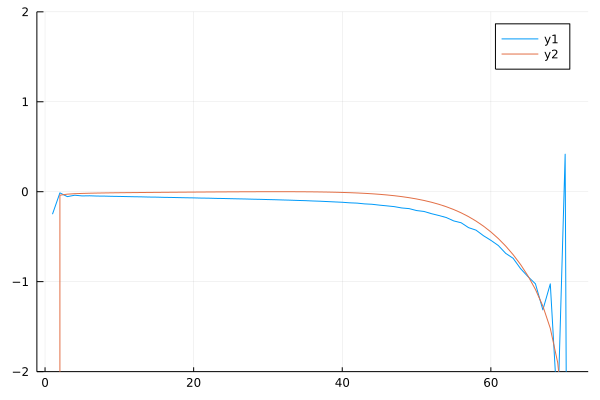

In [656]:
plot(-dp,ylim=(-2,2))
plot!(press.(ζ).-press.(conj(ζ)))

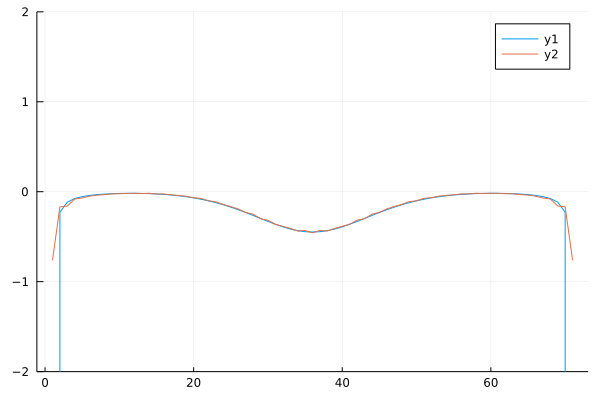

In [642]:
plot(press.(ζ),ylim=(-2,2))
plot!(p⁻)
#plot!(press.(conj(ζ)),ylim=(-2,2))
#plot!(p⁺)

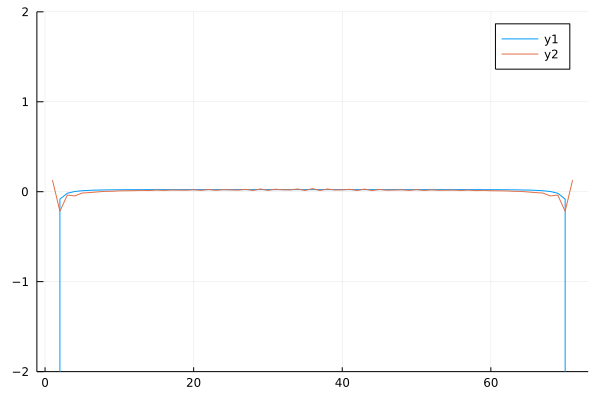

In [643]:
plot(press.(conj(ζ)),ylim=(-2,2))
plot!(p⁺)

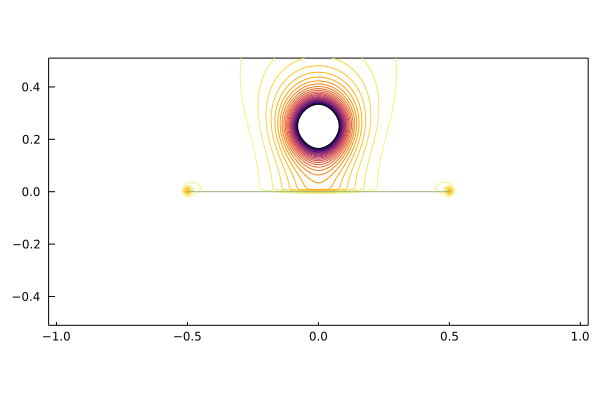

In [644]:
plot(p̄,g,levels=range(-2,0,length=31),clim=(-2,0))
plot!(plate)

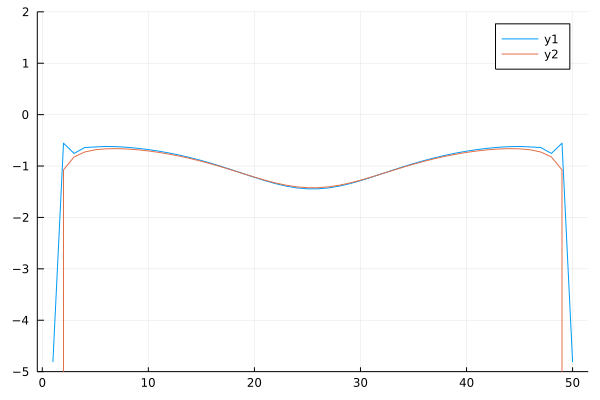

In [570]:
plot(γn)
plot!(γex,ylim=(-5,2))

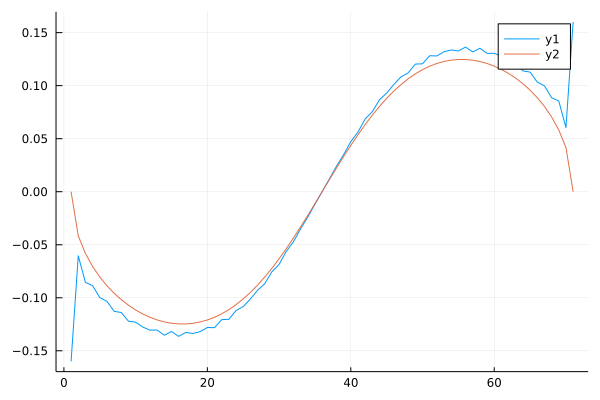

In [336]:
plot(dϕ)
plot!(dϕex)

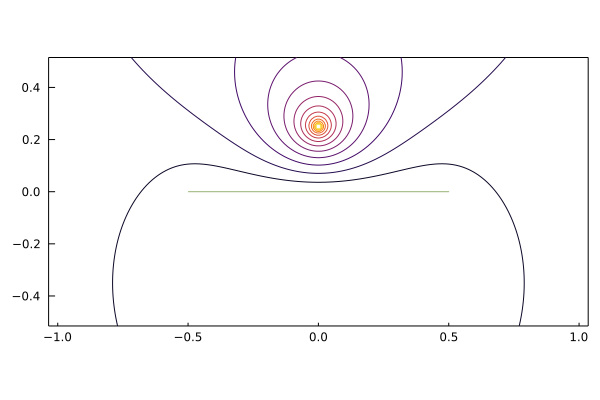

In [337]:
plot(sol.ψ,g)
plot!(plate)

In [97]:
Px_hist = Float64[];
Py_hist = Float64[];

Then we enter a time stepping loop and record the impulse every time we create new vortices. Note that because we release new vortices at every time step, it is not straightforward to use a multi-step time integration method like RK4 to advance the positions of the point vortices. Instead, we use forward Euler and the size of the positions vector increases every time step by the number of new vortices we insert. To advance the system one time step, we first need to solve the saddle-point system, set the strengths of the new vortices, subtract that circulation from the bodies, and calculate the vortex velocities with the saddle-point system solution. For convenience, these four operations are carried out internally if we would call `vortexvelocities!(model)`. However, if we want to have access to the solution of the saddle-point system, we can explicitly perform each operation as is done in the following time stepping loop. Note that we have to set the strengths of the new vortices before calling the `impulse` function, otherwise the new vortices won't be included in the calculation.

In [98]:
sol = solve(model);
for tloc in T[2:end]
    X = getvortexpositions(model) # gets bigger every time step because we add vortices
    Ẋ = deepcopy(X)

    solve!(sol, model)
    Px, Py = impulse(model)

    vortexvelocities!(Ẋ, model, sol.ψ)
    X .= X .+ Ẋ*Δt
    setvortexpositions!(model, X)

    push!(Px_hist,Px)
    push!(Py_hist,Py)
end

In [86]:
getvortexpositions(model)

1 points of vector-valued Float64 data
2-element Vector{Float64}:
 -0.04836462189225335
  0.36683061960407454

In [87]:
solve!(sol,model);

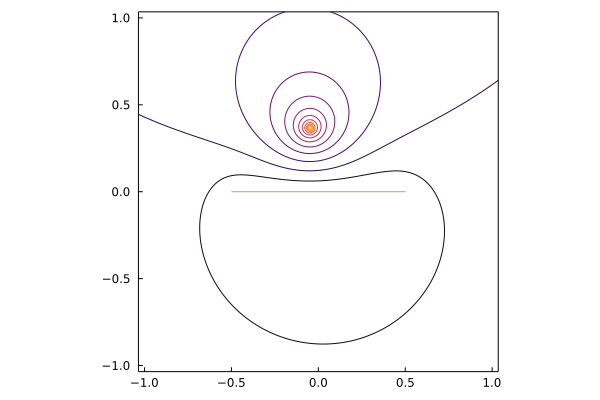

In [88]:
plot(sol.ψ,g)
plot!(plate)

The force history can be obtained by taking finite differences of the impulse history.

In [99]:
Fx_hist = -diff(Px_hist)/Δt;
Fy_hist = -diff(Py_hist)/Δt;

We can now compare the positions of the point vortices by shifting the `PotentialFlow.jl` solution by `-tf*ċ` such that the origin of the frame of reference coincides with the center plate. Superimposing the `GridPotentialFlow.jl` solution then shows that the positions of the point vortices agree very well.

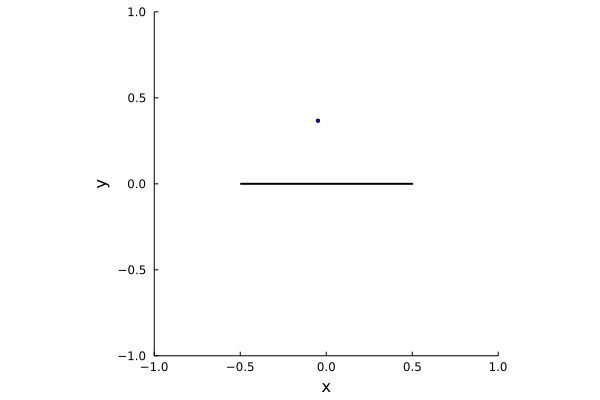

In [72]:
plot(plate,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2,xlim=xlim,ylim=ylim,xlabel="x",ylabel="y")
#scatter!(real.((v->v.z).(sys[2])).-tf*ċ,imag.((v->v.z).(sys[2])),color=:red,markersize=4,label="PotentialFlow.jl")
scatter!(model.vortices.x,model.vortices.y,color=:blue,markersize=2,label="GridPotentialFlow.jl")

The vertical impulse and the vertical force (lift) can also be compared and show good agreement as well.

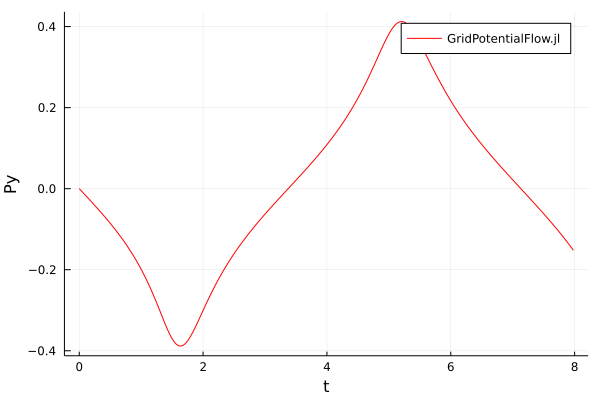

In [101]:
plot(xlabel="t",ylabel="Py")
#plot!(T[1:end-1],imag.(imp),color=:blue,label="PotentialFlow.jl")
plot!(T[1:end-1],Py_hist,color=:red,label="GridPotentialFlow.jl")

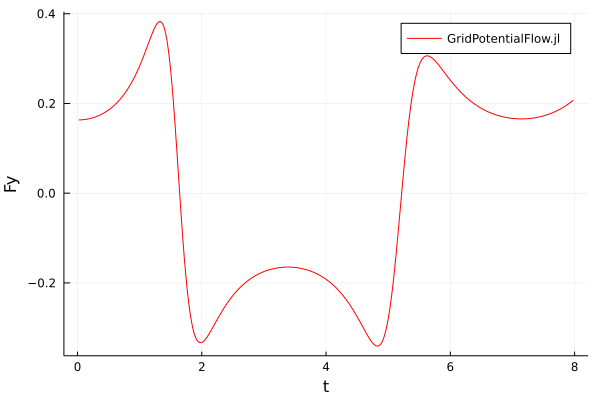

In [100]:
plot(xlabel="t",ylabel="Fy")
#plot!(T[2:end-1],imag.(force),color=:blue,label="PotentialFlow.jl")
plot!(T[2:end-1],Fy_hist,color=:red,label="GridPotentialFlow.jl")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*